In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import numpy.ma as mask
import warnings
import pickle

# Load Data

In [3]:
rating = pd.read_csv("movies_csv/ratings.csv", header = None, names = ['user_id', 'movie_id', 'rating'])
rating_test = pd.read_csv("movies_csv/ratings_test.csv", header = None, names = ['user_id', 'movie_id', 'rating'])

In [4]:
with open('movies_csv/movies.txt', 'rb') as f:
    movie_names = f.readlines()

In [5]:
# preset constant
d = 5
c = 1
sigma = 1

In [6]:
'''
N the len of U vector
M the len of V vector
'''
N = rating['user_id'].unique().size
M = max(rating['movie_id'].unique().size, len(movie_names))
print([N, M])

[943, 1682]


# Implementation of EM

In [12]:

# Implement EM algorithm
class EM:
    def __init__(self, R, U, V, d, c, sigma):
        self.R = R
        self.U = U
        self.V = V
        self.d = d
        self.c = c
        self.sigma = sigma
        self.sigma_square = sigma ** 2

    def Expectation(self):
        prod = np.matmul(self.U, self.V.T) / self.sigma
        cdf_value = stat.norm.cdf(-prod)
        pdf_value = stat.norm.pdf(-prod)
        positive, negative = self.R == -1, self.R == 1
        pos = self.sigma * pdf_value / (1 - cdf_value)
        neg = - self.sigma * pdf_value / cdf_value
        result_Expectation = prod + mask.masked_array(pos, positive).filled(0) + mask.masked_array(neg, negative).filled(0)
        return result_Expectation

    # For the M step, as the U and V are symmetric variables
    # the update of U and V can be achieved by one single function, using a booUpdateU as flag
    # if booUpdateU, then update U
    def Maximization(self, new_vec, booUpdateU=True):
        if booUpdateU:
            inversed = np.linalg.inv(np.identity(d) / self.c + np.matmul(self.V.T, self.V) / self.sigma)
            prod_e = np.matmul(new_vec, self.V) / self.sigma
            new_U = np.matmul(prod_e, inversed)
            self.U = new_U
        else:
            inversed = np.linalg.inv(np.identity(d) / self.c + np.matmul(self.U.T, self.U) / self.sigma)
            prod_e = np.matmul(new_vec.T, self.U) / self.sigma
            new_V = np.matmul(prod_e, inversed)
            self.V = new_V
        return

    def cal_lnP(self):
        const = -(self.U.shape[0] + self.V.shape[0]) * np.log(2 * np.pi * self.c)
        norm_square = - (np.trace(np.inner(self.U, self.U)) + np.trace(np.inner(self.V, self.V))) / (2 * self.c)
        cdf_value = stat.norm.cdf(np.matmul(self.U, self.V.T) / self.sigma)
        positive, negative = self.R == -1, self.R == 1
        pos, neg = np.log(cdf_value), np.log(1-cdf_value)
        result_cal_lnP = const + norm_square + np.sum(mask.masked_array(pos, positive).filled(0)) + np.sum(mask.masked_array(neg, negative).filled(0))
        return result_cal_lnP

   # One single iteration
    def iter(self):
        expectation = self.Expectation()
        update_U = True
        self.Maximization(expectation, update_U)
        expectation = self.Expectation()
        update_U = False
        self.Maximization(expectation, update_U)
        return self.cal_lnP()

    def predict(self, user_id, movie_id):
        prod = np.matmul(self.U[user_id], self.V[movie_id].T)
        pr = stat.norm.cdf(prod)
        if pr > 0.5:
            return 1
        else:
            return -1

# Prepare the data for iteration

In [8]:
# N * M matrix for update preparation
# if some user-movie pairs is not visited in training data, then nan
R_train = np.full([N, M], np.nan)
for index, row in rating.iterrows():
    R_train[row[0]-1][row[1]-1] = row[2] # ID - 1 to fit the index of matrix
# Initialize U and V
ini_sigma_sqaure = 0.1
ini_scale = np.sqrt(ini_sigma_sqaure)
U = np.random.normal(0, ini_scale, (N, d)).astype(np.float64)
V = np.random.normal(0, ini_scale, (M, d)).astype(np.float64)

# a) 100 iterations

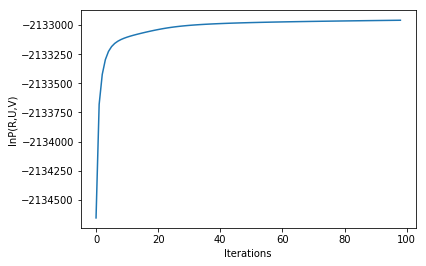

--- 73.28979778289795 seconds for running question (a)---


In [13]:
warnings.filterwarnings('ignore')
start_time = time.time()
model = EM(R_train, U, V, d, c, sigma)
result = []
for i in range(100):
    result.append(model.iter())
plt.plot(np.arange(99), result[1:])
plt.xlabel("Iterations")
plt.ylabel("lnP(R,U,V)")
plt.show()
print("--- %s seconds for running question (a)---" % (time.time() - start_time))

# b) 100 iterations with 5 different random starting point

## 1) Fit the 5 models

In [14]:
warnings.filterwarnings('ignore')
start_time = time.time()
results_folder = []
for i in range(5):
    result = []
    # each time, generate a new random series and fit the model
    U = np.random.normal(0, ini_scale, (N, d)).astype(np.float64)
    V = np.random.normal(0, ini_scale, (M, d)).astype(np.float64)
    model = EM(R_train, U, V, d, c, sigma)
    for _ in range(100):
        result.append(model.iter())
    results_folder.append(result)
    print("Model # %s done" % (i+1))

print("--- %s seconds for running question (b)---" % (time.time() - start_time))
pickle.dump(results_folder, open('results_question_b.pkl', 'wb+'))

Model # 1 done
Model # 2 done
Model # 3 done
Model # 4 done
Model # 5 done
--- 379.7731499671936 seconds for running question (b)---


## 2) Plot the 5 results

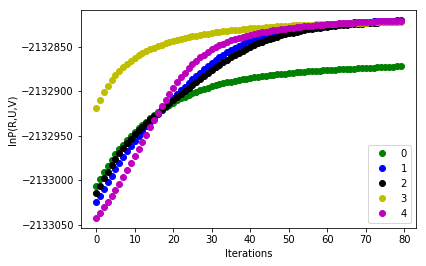

In [15]:
colors = {0: 'g', 1: 'b', 2: 'k', 3: 'y', 4: 'm'}
for i in range(5):
    plt.plot(np.arange(80), results_folder[i][20:], colors[i]+'o', label=str(i))
plt.xlabel("Iterations")
plt.ylabel("lnP(R,U,V)")
plt.legend()
plt.show()

# c) Test set fit Results

In [36]:
warnings.filterwarnings('ignore')
U = np.random.normal(0, ini_scale, (N, d)).astype(np.float64)
V = np.random.normal(0, ini_scale, (M, d)).astype(np.float64)
model = EM(R_train, U, V, d, c, sigma)
result = []
for i in range(300):
    result.append(model.iter())
# initial the confusion matrix
count = np.zeros([2, 2])

for i, row in rating_test.iterrows():
    p = model.predict(row[0]-1, row[1]-1)
    label, p = max(0, row[2]), max(0, p)
    count[label][p] += 1
print(count)
acc = (count[0][0] + count[1][1]) / np.sum(count)
print(acc)

      -1     1
-1  1402   604
1    839  2155
0.71443256
